In [43]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from scipy.interpolate import interpolate
from craftroom import resample
import stistools
from astropy.convolution import convolve, Box1DKernel
from astropy.modeling import models, fitting
from scipy.io.idl import readsav
from astropy.stats import sigma_clip

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20


(Re) extracting the stis data  

In [2]:
path = '/media/david/5tb_storage1/muscles/nuv_ccd_data/'

In [4]:
flts = glob.glob(path+'*flt.fits')
flts

['/media/david/5tb_storage1/muscles/nuv_ccd_data/odlm08020_flt.fits',
 '/media/david/5tb_storage1/muscles/nuv_ccd_data/odlm09020_flt.fits',
 '/media/david/5tb_storage1/muscles/nuv_ccd_data/odlm37020_flt.fits',
 '/media/david/5tb_storage1/muscles/nuv_ccd_data/odlm38020_flt.fits']

In [9]:
def build_trace_grid(SPTRCTAB, grating, cenwave):
    """
    Extends a grid of trace displacements to cover all y positions
    """
    data = fits.getdata(SPTRCTAB, 1)
    tracedata = data[(data['OPT_ELEM']==grating) & (data['CENWAVE'] == cenwave)]
    all_y = np.arange(len(tracedata[0]['A2DISPL']))
    grid = interpolate.interp1d(tracedata['A2CENTER'], tracedata['A2DISPL'], axis=0, fill_value='extrapolate')(all_y)
    tracegrid = [a+b for a, b in zip(grid, all_y)] 
    return tracegrid

def get_a2center(x, y, tracegrid):
    """
    get the trace a2center at a1center
    """
    xcol = np.array(tracegrid)[:,int(x)]
    xind = (np.abs(xcol - y)).argmin()
    a2center = xind + 1 #calstis is 1-indexed 
    return a2center

def no_zero_errors(flux, error):
    """
    Corrects instances where negative flux measurements have very small errors
    """
    e_new = error
    for i in range(len(error)):
        if flux[i] < 0.0 and error[i] < 0.1*abs(flux[i]):
            e_new[i] = abs(flux[i])
    return e_new

def new_coadd(f_array, e_array):
    weights = 1 / (e_array**2)
    flux = np.average(f_array, axis =0, weights = weights)
    var = 1 / np.sum(weights, axis=0)
    rcs = np.sum(((flux - f_array)**2) * weights, axis=0) / (len(f_array)-1)
    error = (var * rcs)**0.5
    return flux, error

In [14]:
os.environ['oref']=path


GJ15A odlm08020


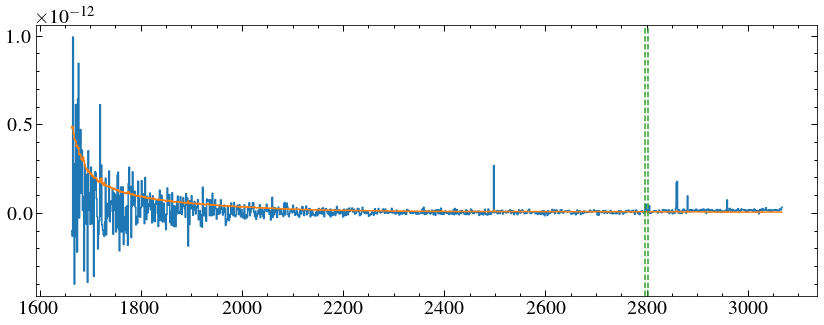

GJ15A odlm09020


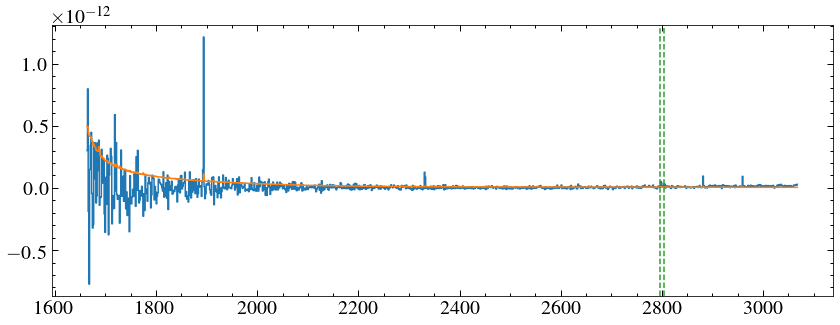

GJ729 odlm37020


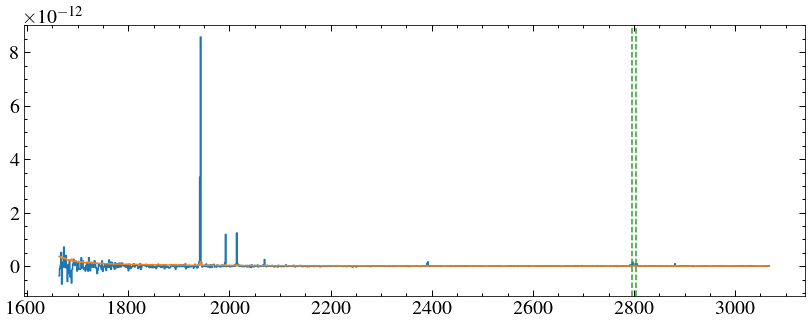

GJ729 odlm38020


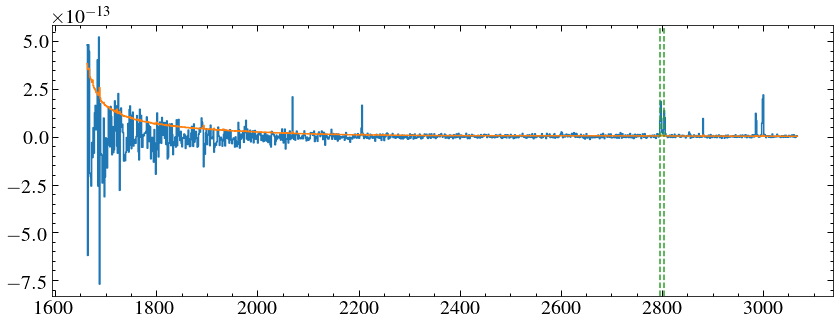

In [23]:
centab = Table.read('ccd_trace_centers.ecsv')
outpath = 'nuv_extractions/'
flts = glob.glob(path+'*flt.fits')
for fl in glob.glob(outpath+'*.fits'):
    os.remove(fl)

mg_lines =  [2796.35, 2803.55]
    
for flt in flts: 
    hdr = fits.getheader(flt, 0)
    target = hdr['TARGNAME']
    rootname = hdr['ROOTNAME']
    SPTRCTAB = hdr['SPTRCTAB']
    grating = hdr['OPT_ELEM']
    cenwave = hdr['CENWAVE']
    tracegrid = build_trace_grid('/home/david/crds_cache/references/hst/oref/'+SPTRCTAB[5:], grating, cenwave)
    rootarg = np.argwhere(centab['ROOTNAME']==rootname)[0][0]
    x = centab['XCOL'][rootarg]
    y = centab['A2CENTER'][rootarg]
    a2center = get_a2center(x,y, tracegrid)#adjust measured a2 center to central point
    stistools.x1d.x1d(flt, output=outpath+rootname+'_sx1.fits', verbose=False, 
                      trailer='trl_files/'+rootname+'.trl',a2center=a2center,maxsrch=0)
    x = outpath+rootname+'_sx1.fits'
    data = fits.getdata(x, 1)[0]
    wi, fi, ei = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    plt.step(wi, fi, where='mid')
    plt.step(wi, ei, where='mid')
    [plt.axvline(line, ls='--', c='C2') for line in mg_lines]
    print(target, rootname)
    plt.show()
     

GJ15A


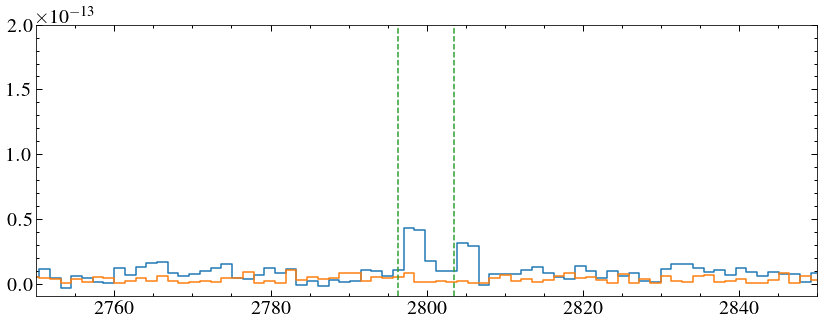

GJ729


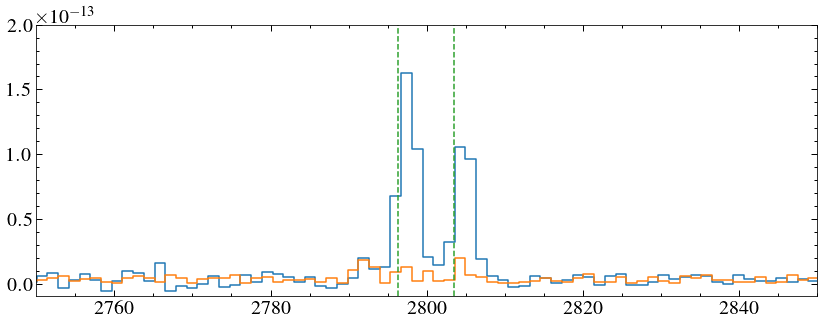

In [51]:
stars = ['GJ15A', 'GJ729']
new_sx1s = glob.glob('nuv_extractions/*sx1.fits')
opath = 'nuv_coadds/'
for star in stars:
    fs = []
    es = []
    first = True
    for x in new_sx1s:
        hdul = fits.open(x)
        target = hdul[0].header['TARGNAME']
        rootname = hdul[0].header['ROOTNAME']
        if target == star:
                data = hdul[1].data[0]
                wi, fi, ei, dqi = data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['DQ']
               # wi, fi, ei = wi[dqi==0], fi[dqi==0], ei[dqi==0]
                ei = no_zero_errors(fi, ei) 
                if  first:
                    w_new = wi
                    first = False
                else:
                    fi = interpolate.interp1d(wi, fi, fill_value='extrapolate')(w_new)
                    ei = interpolate.interp1d(wi, ei, fill_value='extrapolate')(w_new)
                fs.append(fi)
                es.append(ei)
        hdul.close()
    f_new, e_new = new_coadd(np.array(fs), np.array(es))
    #mask = (e_new < 3*f_new)
    #w_new, f_new, e_new = w_new[mask], f_new[mask], e_new[mask]
    #f_new = sigma_clip(f_new, 5)
    plt.step(w_new, f_new, where='mid')
    plt.step(w_new, e_new, where='mid')
    [plt.axvline(line, ls='--', c='C2') for line in mg_lines]
  #  print(target, rootname)
    print(star)
    #plt.yscale('log')
    #plt.xscale('log')
    plt.ylim(-0.1e-13, 2e-13)
    plt.xlim(2750, 2850)
    plt.show()
    savdat = Table((w_new*u.AA, f_new*u.erg/u.s/u.cm**2/u.AA, e_new*u.erg/u.s/u.cm**2/u.AA), names=['WAVELENGTH', 'FLUX', 'ERROR'])
    ascii.write(savdat, opath+star+'_g230lb_coadd_v1.ecsv', overwrite=True, format='ecsv')
    
                                                                
